<a href="https://colab.research.google.com/github/Iaquine/Implementa-o-K-means-dataset-HAR/blob/master/Implementa%C3%A7%C3%A3o_do_K_means_com_o_dataset_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import zipfile

In [11]:
# 1.1. Acesso ao Conjunto de Dados

In [10]:
def extract_dataset(zip_path="./human_activity_recognition_using_smartphones.zip", extract_to="./UCI HAR Dataset"):
    """
    Extrai o arquivo ZIP contendo o dataset.
    """
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Arquivo ZIP '{zip_path}' não encontrado no diretório do projeto.")

    # Extrair apenas se a pasta de destino não existir
    if not os.path.exists(extract_to):
        print("Extraindo os dados...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(".")  # Extrai no diretório atual
        print("Extração concluída!")

def load_dataset(dataset_path="./UCI HAR Dataset"):
    """
    Carrega o dataset de Human Activity Recognition.
    """
    # Verificar se o caminho existe
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"O caminho especificado '{dataset_path}' não foi encontrado. "
                                "Certifique-se de que o dataset foi extraído corretamente.")

    # Carregar os nomes das features
    features_path = os.path.join(dataset_path, "features.txt")
    features = pd.read_csv(features_path, sep=r'\s+', header=None, names=["index", "feature"])

    # Garantir que não há colunas duplicadas
    features["feature"] = features["feature"].apply(lambda x: x.strip())  # Remover espaços extras
    column_names = features["feature"].unique().tolist()  # Usar nomes únicos

    # Carregar rótulos de atividades
    activity_labels_path = os.path.join(dataset_path, "activity_labels.txt")
    activity_labels = pd.read_csv(activity_labels_path, sep=r'\s+', header=None, names=["ActivityID", "ActivityName"])

    # Carregar dados de treino
    x_train_path = os.path.join(dataset_path, "train/X_train.txt")
    y_train_path = os.path.join(dataset_path, "train/y_train.txt")
    subject_train_path = os.path.join(dataset_path, "train/subject_train.txt")

    x_train = pd.read_csv(x_train_path, sep=r'\s+', header=None, names=column_names)
    y_train = pd.read_csv(y_train_path, header=None, names=["Activity"])
    subject_train = pd.read_csv(subject_train_path, header=None, names=["Subject"])

    # Combinar os dados de treino
    train_data = pd.concat([subject_train, y_train, x_train], axis=1)

    # Carregar dados de teste
    x_test_path = os.path.join(dataset_path, "test/X_test.txt")
    y_test_path = os.path.join(dataset_path, "test/y_test.txt")
    subject_test_path = os.path.join(dataset_path, "test/subject_test.txt")

    x_test = pd.read_csv(x_test_path, sep=r'\s+', header=None, names=column_names)
    y_test = pd.read_csv(y_test_path, header=None, names=["Activity"])
    subject_test = pd.read_csv(subject_test_path, header=None, names=["Subject"])

    # Combinar os dados de teste
    test_data = pd.concat([subject_test, y_test, x_test], axis=1)

    return train_data, test_data, activity_labels, column_names

# Extração e carregamento do dataset
try:
    zip_file_path = "/content/UCI HAR Dataset.zip"
    extract_dataset(zip_path=zip_file_path)  # Extrai o ZIP
    train_data, test_data, activity_labels, features = load_dataset()
    print("Dados carregados com sucesso!")
    print(f"Dados de treino: {train_data.shape}")
    print(f"Dados de teste: {test_data.shape}")
except FileNotFoundError as e:
    print(e)
except ValueError as e:
    print(f"Erro ao carregar os dados: {e}")

Dados carregados com sucesso!
Dados de treino: (14704, 479)
Dados de teste: (5894, 479)


In [19]:
def load_dataset(base_path):
    """
    Carrega o dataset de Human Activity Recognition a partir da estrutura de pastas fornecida.
    """
    # Caminhos dos arquivos
    features_path = os.path.join(base_path, 'features.txt')
    x_train_path = os.path.join(base_path, 'train/X_train.txt')
    y_train_path = os.path.join(base_path, 'train/y_train.txt')
    x_test_path = os.path.join(base_path, 'test/X_test.txt')
    y_test_path = os.path.join(base_path, 'test/y_test.txt')

    # Carregando as features
    features = pd.read_csv(features_path, sep='\s+', header=None, names=["index", "feature"])

    # Garantir que os nomes das features sejam únicos, removendo espaços extras
    features['feature'] = features['feature'].str.replace(r'\s+', '_', regex=True)

    column_names = features['feature'].tolist()

    # Garantir nomes de colunas exclusivos
    # Se houver duplicação, renomear as colunas adicionando um índice incremental
    def make_unique(names):
        seen = {}
        unique_names = []
        for name in names:
            if name in seen:
                seen[name] += 1
                unique_name = f"{name}_{seen[name]}"
            else:
                seen[name] = 0
                unique_name = name
            unique_names.append(unique_name)
        return unique_names

    column_names = make_unique(column_names)

    # Carregando os dados de treino e teste
    x_train = pd.read_csv(x_train_path, sep='\s+', header=None, names=column_names)
    y_train = pd.read_csv(y_train_path, header=None, names=["Activity"])

    x_test = pd.read_csv(x_test_path, sep='\s+', header=None, names=column_names)
    y_test = pd.read_csv(y_test_path, header=None, names=["Activity"])

    return x_train, y_train, x_test, y_test, column_names

# Caminho base do dataset
base_path = "UCI HAR Dataset"  # Defina o caminho correto conforme seu diretório local

# Carregar os dados
x_train, y_train, x_test, y_test, features = load_dataset(base_path)

# Verificar se as colunas foram carregadas corretamente
print(x_train.info())

# Exibir as primeiras linhas para verificar os dados
print(x_train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0           0.288585          -0.020294          -0.132905         -0.995279   
1           0.278419          -0.016411          -0.123520         -0.998245   
2           0.279653          -0.019467          -0.113462         -0.995380   
3           0.279174          -0.026201          -0.123283         -0.996091   
4           0.276629          -0.016570          -0.115362         -0.998139   

   tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  \
0         -0.983111         -0.913526         -0.995112         -0.983185   
1         -0.975300         -0.960322         -0.998807         -0.974914   
2         -0.967187         -0.978944         -0.996520         -0.963668   
3         -0.983403      

In [20]:
# Verificar se as colunas foram carregadas corretamente
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [23]:
x_train

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,0.210795,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,0.117440,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,0.043999,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,0.101702,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


In [22]:
# 1.2. Análise Exploratória
print("Visão geral dos dados:")
print(x_train.info())
print(x_train.describe())

Visão geral dos dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None
       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
count        7352.000000        7352.000000        7352.000000   
mean            0.274488          -0.017695          -0.109141   
std             0.070261           0.040811           0.056635   
min            -1.000000          -1.000000          -1.000000   
25%             0.262975          -0.024863          -0.120993   
50%             0.277193          -0.017219          -0.108676   
75%             0.288461          -0.010783          -0.097794   
max             1.000000           1.000000           1.000000   

       tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
count       7352.000000       7352.000000       7352.000000       7352.000000   
mean          -0.605438         -0

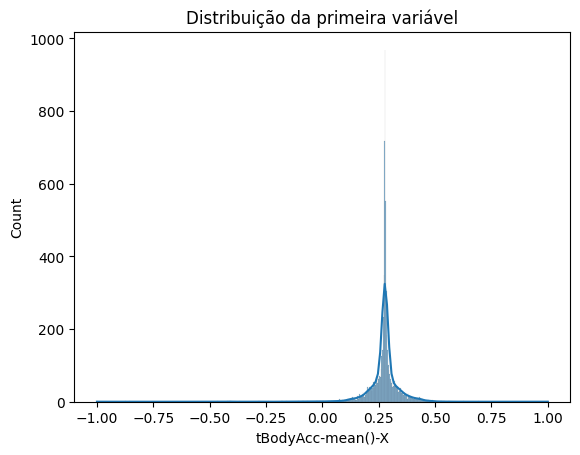

In [24]:
# Verificar distribuições
sns.histplot(x_train.iloc[:, 0], kde=True)
plt.title("Distribuição da primeira variável")
plt.show()

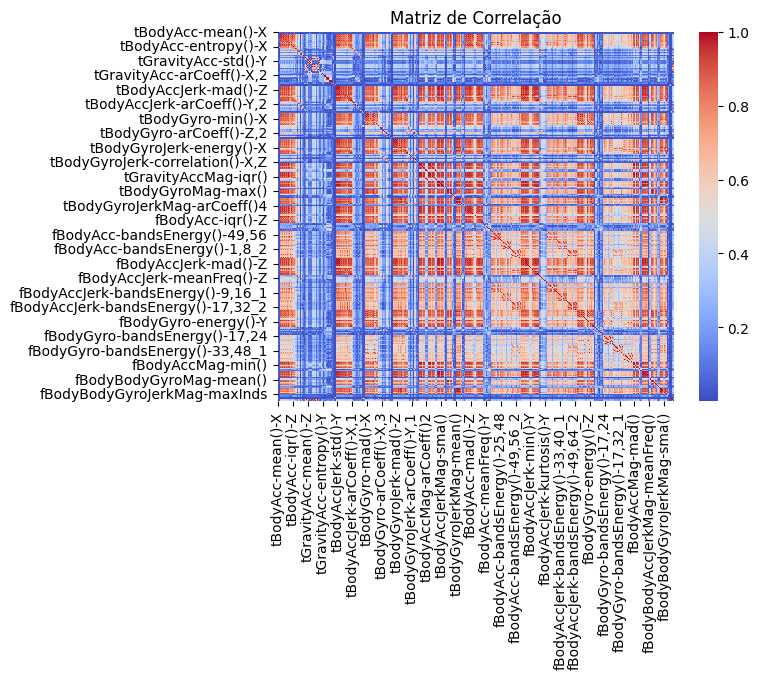

In [25]:
# 1.3. Avaliar correlações
correlation_matrix = x_train.corr().abs()
sns.heatmap(correlation_matrix, cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [48]:
# 2.1. Reduzir dimensionalidade com PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(x_train)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

In [49]:
# 2.2. Determinar o número ideal de clusters (K)
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(pca_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(pca_data, kmeans.labels_))

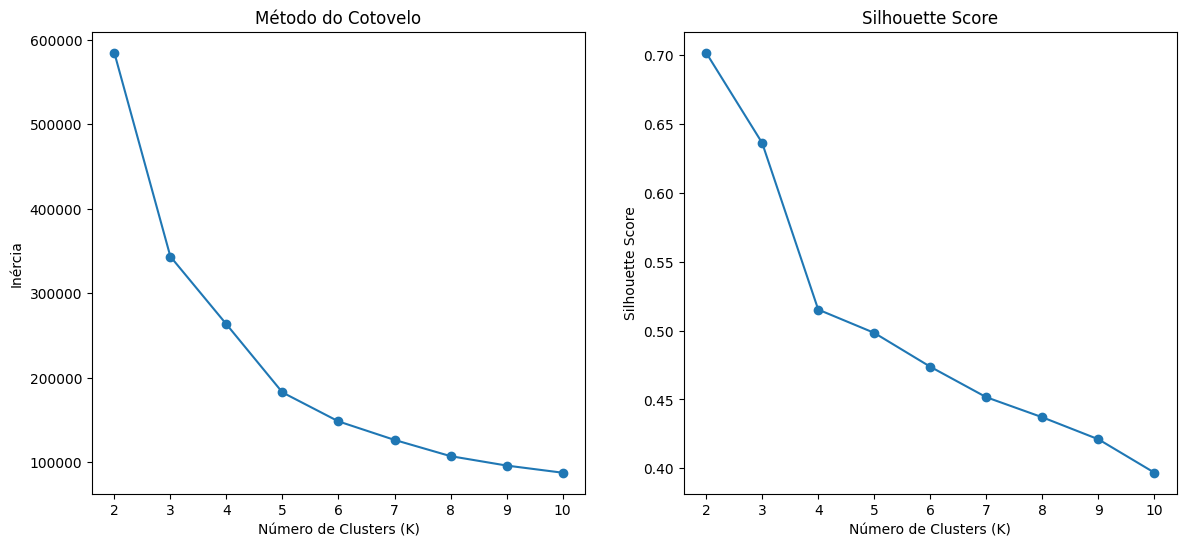

In [50]:
# Gráficos para escolha do número de clusters
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title("Método do Cotovelo")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Inércia")

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title("Silhouette Score")
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silhouette Score")
plt.show()

In [52]:
# Escolha final de K
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"Número ideal de clusters: {optimal_k}")

Número ideal de clusters: 2


In [58]:
# 3.1. Inicialização com K-means++
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42)
kmeans.fit(pca_data)

KMeans(n_clusters=2, random_state=42)

In [59]:
# 3.2. Normalização e estabilidade
clusters = kmeans.labels_

In [60]:
# 3.3. Verificar estabilidade
print(f"Centroides: {kmeans.cluster_centers_}")


Centroides: [[-13.97951941   1.02105353]
 [ 17.24084107  -1.259258  ]]


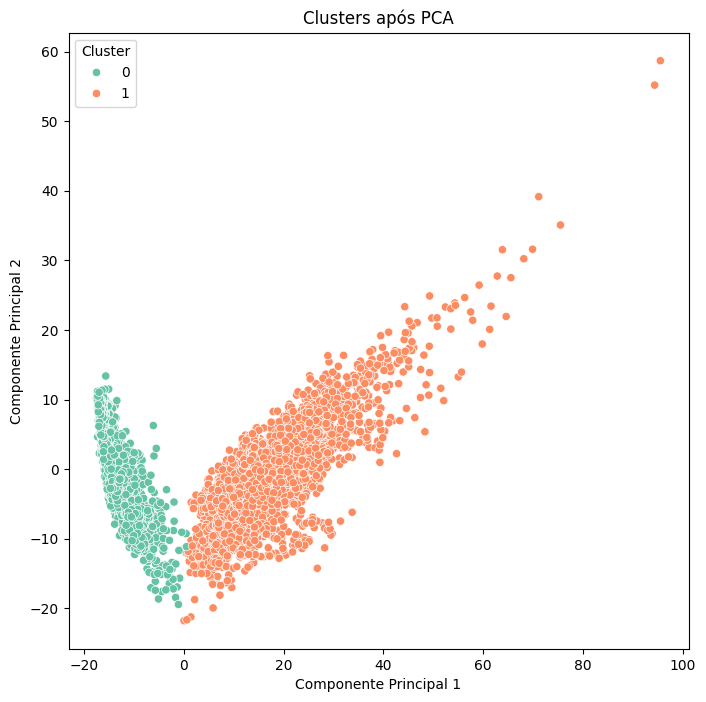

In [61]:
# 4.1. Visualização dos Clusters
plt.figure(figsize=(8, 8))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette="Set2", legend="full")
plt.title("Clusters após PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()

In [62]:
# 4.2. Métricas de Avaliação
silhouette_avg = silhouette_score(pca_data, clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.7015910743071301
